In [3]:
!which python

/home/jungadam/anaconda3/envs/pytorch_gpu/bin/python


In [4]:
import sys
print(sys.executable)

/home/jungadam/anaconda3/envs/pytorch_gpu/bin/python


In [5]:
import numpy
import scipy.stats
import datetime
import matplotlib.pyplot
from exp import load_data
import sklearn.model_selection
import utils
from GP_Beta_cal import GP_Beta
from sklearn.isotonic import IsotonicRegression
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

Specify the uncalibrated base model and dataset

For base models: 'olr' (ordinary least square), 'deep' (deep nets with drop out approximation), 'br' (bayesian ridge regression), 'gp' (Gaussian process regression)

For datasets: 0. diabetes, 1. boston, 2. arifoil, 3. forest fire, 4.strength, 5.energy

In [2]:
base = 'olr'
dataset = 2

Load the boston dataset and split into training and testing sets.

In [3]:
# (x_raw, y_raw) = load_data(dataset, base)
_xy = numpy.loadtxt("../toy_data.csv", skiprows = 1, delimiter = ",")
(x_raw, y_raw) = _xy[:, 0:1], _xy[:, 1:2]

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_raw, y_raw.ravel(),
                                                                            test_size=0.25, shuffle=True)

y_train = y_train.reshape(-1, 1)

y_test = y_test.reshape(-1, 1)

Train a simple linear regression, and obtain its prediction (mean and std).  

In [4]:
base_model = utils.get_mdl(x_train, y_train, base) # change 'olr' to 'deep' / 'br' / 'gp' for other base models

Create a calibration set by collecting model prediction (mean and std).  

In [5]:
mu_cal, sigma_cal = utils.get_prediction(x_train, base_model)

Specify the bins edges to calculate the corresponding PDF / CDF values

Train the GP-Beta calibrator

In [11]:
y_train.shape

(270, 1)

In [13]:
mu_cal.shape

(270, 1)

In [21]:
sigma_cal.flatten().reshape(-1, 1).shape

(270, 1)

In [10]:
y_train, mu_cal, sigma_cal

(array([[ 7.22e+00],
        [ 1.77e+01],
        [ 1.72e-01],
        [ 2.36e-01],
        [ 5.49e+00],
        [-3.99e+00],
        [-2.92e-01],
        [ 1.52e+00],
        [-1.37e+00],
        [ 1.39e+01],
        [-6.09e-01],
        [ 8.97e-01],
        [-1.23e-01],
        [ 2.79e+00],
        [ 1.56e+01],
        [ 2.19e+01],
        [ 1.47e+01],
        [ 1.85e+01],
        [ 1.60e+01],
        [ 1.17e+00],
        [-2.60e+00],
        [ 4.09e-01],
        [ 6.80e+00],
        [-1.29e+00],
        [ 3.02e+00],
        [ 1.72e+01],
        [-4.48e-01],
        [-1.82e+00],
        [ 1.66e+01],
        [ 1.16e+00],
        [ 1.34e+01],
        [-5.70e-01],
        [-2.64e+00],
        [ 4.17e+00],
        [ 1.43e+01],
        [-5.11e+00],
        [ 5.31e+00],
        [-1.96e+00],
        [-7.35e-01],
        [ 1.46e+00],
        [-6.19e+00],
        [ 2.05e+01],
        [-1.29e+00],
        [-1.22e+00],
        [-4.12e+00],
        [-3.89e+00],
        [-8.01e-01],
        [-7.0

In [6]:
n_u = 8 # number of induced points
print('training size: ' + str(len(y_train)))
print('induced points: ' + str(n_u))
GP_Beta_mdl = GP_Beta()
start_time = datetime.datetime.now()
GP_Beta_mdl.fit(y_train, mu_cal, sigma_cal, n_u=n_u, 
                plot_loss=False, print_info=False)
end_time = datetime.datetime.now()
print('training time: ' + str((end_time - start_time).total_seconds()) + ' seconds')

training size: 270
induced points: 8
learning rate: 0.01
Total batch number: 641
Initial Loss: 3.579341717946801
Final Loss: 3.0682543734445957
Current Improvement, Initial Improvement * factr
[0.00e+00 3.32e-09]
training time: 134.998383 seconds


Train the isotonic quantile calibrator

In [7]:
iso_q, iso_q_hat = utils.get_iso_cal_table(y_train, mu_cal, sigma_cal)

iso_mdl = IsotonicRegression(out_of_bounds='clip')

iso_mdl.fit(iso_q, iso_q_hat)

IsotonicRegression(out_of_bounds='clip')

Obtain base model prediction on the testing set, as well as predicted PDF and CDF

In [8]:
mu_base, sigma_base = utils.get_prediction(x_test, base_model)

n_t_test = 1024

t_list_test = numpy.linspace(numpy.min(mu_base) - 16.0 * numpy.max(sigma_base),
                             numpy.max(mu_base) + 16.0 * numpy.max(sigma_base),
                             n_t_test).reshape(1, -1)

y_base = mu_base.ravel()

q_base, s_base = utils.get_norm_q(mu_base.ravel(), sigma_base.ravel(), t_list_test.ravel())

Apply GP-Beta calibrator to get predicted target value, negtive log-likelihood, PDF and CDF

In [9]:
s_gp, q_gp = GP_Beta_mdl.predict(t_list_test, mu_base, sigma_base)

y_gp = utils.get_y_hat(t_list_test.ravel(), s_gp)

exception calling callback for <Future at 0x7fcff0082780 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/jungadam/anaconda3/envs/distcal/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/jungadam/anaconda3/envs/distcal/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/mnt/idms/home/jungadam/spring/experiment/recalib_models/GPBETA/DistCal/GP_Beta_cal.py", line 646, in <module>
    def kernel_diag(theta, mu, sigma, jitter=tf.constant(1e-2, dtype='float64')):
  File "/home/jungadam/anaconda3/envs/distcal/lib/python3.6/site-packages/tensorflow_core/python/framework/constant_op.py", line 227, in constant
    allow_broadcast=True)
  File "/home/jungadam/anaconda3/envs/distcal/lib/python3.6/site-packages/tensorfl

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
help(GP_Beta_mdl.predict)

In [88]:
q_gp.shape

(90, 1024)

In [89]:
s_gp.shape

(90, 1024)

Apply isotonic calibrator to get predicted target value, negtive log-likelihood, PDF and CDF

In [66]:
q_iso = iso_mdl.predict(q_base.ravel()).reshape(numpy.shape(q_base))

s_iso = numpy.diff(q_iso, axis=1) / \
        (t_list_test[0, 1:] - t_list_test[0, :-1]).ravel().reshape(1, -1).repeat(len(y_test), axis=0)

y_iso = utils.get_y_hat(t_list_test.ravel(), s_iso)

Plot PDF / calibration map / CDF for 3 random test instances

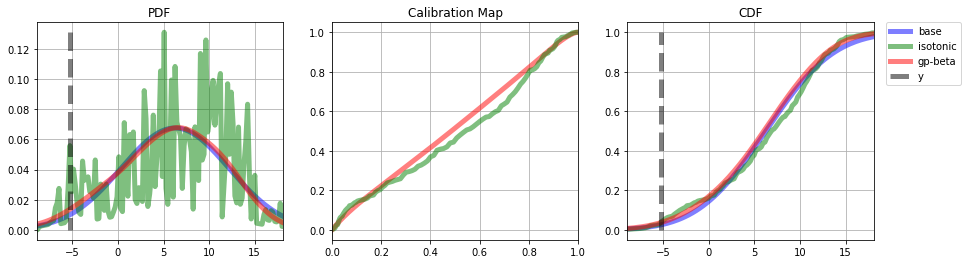

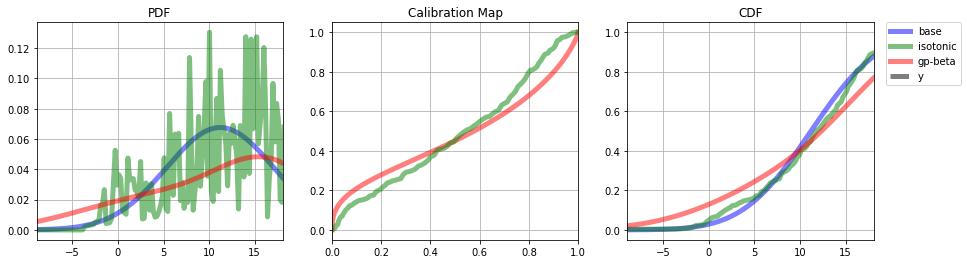

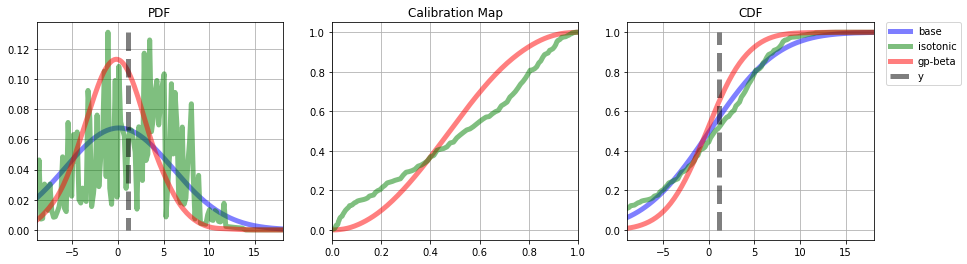

In [78]:
t_list = t_list_test.copy()

y = y_test.copy()

t_list_mid = (t_list[0, 1:] + t_list[0, 0:-1]) / 2

t_list = t_list.ravel()

for i in numpy.random.permutation(numpy.arange(0, len(y)))[:3]:

    fig, ax_list = matplotlib.pyplot.subplots(1, 3, figsize=(15, 4))

    ax_list[2].plot(t_list, q_base[i, :], 'b', alpha=0.5, linewidth=5)

    ax_list[2].plot(t_list, q_iso[i, :], 'g', alpha=0.5, linewidth=5)

    ax_list[2].plot(t_list, q_gp[i, :], 'r', alpha=0.5, linewidth=5)

    ax_list[2].plot([y[i], y[i]], [0, 1], 'k--', linewidth=5, alpha=0.5)

    ax_list[0].plot(t_list, s_base[i, :], 'b', alpha=0.5, linewidth=5)

    ax_list[0].plot(t_list_mid, s_iso[i, :], 'g', alpha=0.5, linewidth=5)

    ax_list[0].plot(t_list, s_gp[i, :], 'r', alpha=0.5, linewidth=5)

    max_density = numpy.max(numpy.concatenate([s_base[i, :].ravel(), s_iso[i, :].ravel(), s_gp[i, :].ravel()]))

    ax_list[0].plot([y[i], y[i]], [max_density, 0], 'k--', linewidth=5, alpha=0.5)

    ax_list[0].set_title('PDF')

    ax_list[1].plot(q_base[i, :], q_gp[i, :], 'r', alpha=0.5, linewidth=5)

    ax_list[1].plot(q_base[i, :], q_iso[i, :], 'g', alpha=0.5, linewidth=5)

    ax_list[0].set_xlim([numpy.min(mu_cal) - numpy.max(sigma_cal), 
                         numpy.max(mu_cal) + numpy.max(sigma_cal)])
    
    ax_list[2].set_xlim([numpy.min(mu_cal) - numpy.max(sigma_cal), 
                         numpy.max(mu_cal) + numpy.max(sigma_cal)])

    ax_list[1].set_xlim([0, 1])

    ax_list[1].set_title('Calibration Map')

    ax_list[2].set_title('CDF')

    ax_list[2].legend(['base', 'isotonic', 'gp-beta', 'y'],
                        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    ax_list[0].grid(True)

    ax_list[1].grid(True)

    ax_list[2].grid(True)

Evaluate negative log-likelihood, pin-ball loss, and MSE

In [68]:
ll_base = - scipy.stats.norm.logpdf(y_test.reshape(-1, 1),
                                    loc=mu_base.reshape(-1, 1),
                                    scale=sigma_base.reshape(-1, 1)).ravel()
ll_iso = utils.get_log_loss(y_test, t_list_test.ravel(), s_iso)
ll_gp = utils.get_log_loss(y_test, t_list_test.ravel(), s_gp)
print([numpy.mean(ll_base), numpy.mean(ll_iso), numpy.mean(ll_gp)])

[3.2049705768018395, 3.426897504333528, 3.000852461223614]


In [95]:
eps = numpy.finfo(numpy.random.randn(1).dtype).eps
eps
-numpy.log(eps)

36.04365338911715

In [69]:
pbl_base = utils.get_pin_ball_loss(y_test, q_base, t_list_test.ravel())
pbl_iso = utils.get_pin_ball_loss(y_test, q_iso, t_list_test.ravel())
pbl_gp = utils.get_pin_ball_loss(y_test, q_gp, t_list_test.ravel())
print([pbl_base[0], pbl_iso[0], pbl_gp[0]])

[1.8013596453770573, 1.8020750562544083, 1.6741111213696858]


In [70]:
se_base = utils.get_se(y_base, y_test)
se_iso = utils.get_se(y_iso, y_test)
se_gp = utils.get_se(y_gp, y_test)
print([numpy.mean(se_base), numpy.mean(se_iso), numpy.mean(se_gp)])

[35.581854522239304, 35.5646676533264, 35.413914926286026]
